<a href="https://colab.research.google.com/github/nohasamir89/noha_project/blob/main/google_colabs/Embed_sequences_using_TM_Vec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes:
1. In order to use TM-Vec and DeepBlast, you need to install TM-Vec, DeepBlast, and the huggingface transformers library.
2. You will also need to download the ProtT5-XL-UniRef50 encoder (large language model that TM-Vec and DeepBlast uses), the trained TM-Vec model, and the trained DeepBlast model. As the ProtT5-XL-UniRef50 encoder is very large (~11.3GB), unless you have the necessary RAM on your GPU (at least more than the model), you may have to use a CPU runtime on Google Colab.
3. This notebook demonstrates how TM-Vec can be used to embed protein sequences.


<h3>Embedding protein sequences using a trained TM-Vec model</h3>

**1. Install the relevant libraries including tm-vec, the huggingface transformers library, and faiss**

In [1]:
%pip install git+https://github.com/tymor22/tm-vec.git -q gwpy
%pip install -q SentencePiece transformers
%pip install faiss-cpu

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 19.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 27.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 34.1 MB/s eta 0:00:00


<b>2. Load the relevant libraries<b>

In [3]:
import torch
from transformers import T5EncoderModel, T5Tokenizer
import re
import gc
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset
import faiss
from tm_vec.embed_structure_model import trans_basic_block, trans_basic_block_Config
from tm_vec.tm_vec_utils import featurize_prottrans, embed_tm_vec, encode
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

<b>3. Load the ProtT5-XL-UniRef50 tokenizer and model<b>

In [4]:
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")
gc.collect()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


pytorch_model.bin:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

71

<b>3. Put the model onto your GPU if it is avilabile, switching the model to inference mode<b>

In [5]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)
model = model.to(device)
model = model.eval()

cpu


<b>4. Download a trained TM-Vec model, and its configuration file<b>

In [6]:
!wget https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model.ckpt -q gwpy
!wget https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model_params.json -q gwpy

<b> 5. Load a trained TM-Vec model<b>

In [7]:
#TM-Vec model paths
tm_vec_model_cpnt = "tm_vec_cath_model.ckpt"
tm_vec_model_config = "tm_vec_cath_model_params.json"

#Load the TM-Vec model
tm_vec_model_config = trans_basic_block_Config.from_json(tm_vec_model_config)
model_deep = trans_basic_block.load_from_checkpoint(tm_vec_model_cpnt, config=tm_vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

FileNotFoundError: [Errno 2] No such file or directory: 'tm_vec_cath_model_params.json'

<b> 6. Load or paste some sequences that you would like to embed <b>

In [ ]:
#Here we download CATH-S35 data and sample
!wget https://users.flatironinstitute.org/thamamsy/public_www/cath-domain-seqs-S35-with-metadata.tsv  -q gwpy

In [ ]:
#Read in some sequences, sample a few, and put them in a list
cath_data = pd.read_csv('cath-domain-seqs-S35-with-metadata.tsv', sep="\t")
cath_data_sample = cath_data.sample(50)
sequences = list(cath_data_sample['Sequence'].values)

In [ ]:
print("Example sequences:")
print(sequences[0:5])

Example sequences:
['GXAGAAHRLXEARXRRYDNKFARISDIDINQPESWRGRIFLTFDIDWAADFVLQDTIDLIEGAGVCATWFATHSTPLLENIRRNPLFELGVHPNFNPLLAGAHAEGVQEILDRTLELAPGCVSVRSHSLVQATSILNXFGERRLRYDCNILVPWDAGIVLQPWRHWTGDXVRVPYLWEDDVACLYDWEFDSTFDYWYQPDGINVLDFHPIHVYXNTESLRRYEDSREVHRNPVDLIRWRNTSAGSRTFLQSLLARNI', 'GTVNNELGYQLFRDFAENKGMFRPGATNIAIYNKQGEFVGTLDKAAMPDFSAVDSEIGVATLINPQYIASVKHNGGYTNVSFGDGENRYNIVDRNNAPSLDFHAPRLDKLVTEVAPTAVTAQGAVAGAYLDKERYPVFYRLGSGTQYIKDSNGQLTKMGGAYSWLTGGTVGSLSSYQNGEMISTSSGLVFDYKLNGAMPIYGEAGDSGSPLFAFDTVQNKWVLVGVLTAGNGAGGRGNNWAVIPLDFIGQKFNEDND', 'VEVGGGNDIDITTVDFIMSIGRGIGEETNVEQFRELADEAGATLCCSCPIADAGWLPKSRQVGQSGKVVGSCKLYVAMGISGSIQHMAGMKHVPTIIAVNTDPGASIFTIAKYGIVADIFDIEEELKAQLAA', 'MSGDTTLVDTVNASQSRQVFWDRDVYDLEIERIFEFRFYLDTIWEGGGAGLELLGPPMKSLLHCNWKVPVENFVGDGYHVGWTHAAALGQIGGPLAGLAGNRADIPFDDLGLQFTTRHGHGFGVIDNAAAAIHRKGDGWNKYLEDTRGEVRRKFGADRERLYVGHWNGAIFPNCSFLYGTNTFKIWHPRGPHEIEVWTYTMVPSDADPATKSAIQREATRTFGTAGTLESDDGENMSSATYVNRGVITRDGMMNSTMGVGYEGPHPVYPGIVGISFIGETSYRGFYRFWKEMIDAPDWASVKANDDNWDSVFTNRNFWNEK

<b> 7. Embed your sequences using TM-Vec <b>



In [ ]:
encoded_sequences = encode(sequences, model_deep, model, tokenizer, device)

<b>8. Visualize your embedded sequences<b>

In [ ]:
sequence_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(encoded_sequences)

In [ ]:
#Make the relevant dataframe and add the metadata to it
sequence_tsne_df = pd.DataFrame(sequence_tsne)
sequence_tsne_df.columns = ["Dim1", "Dim2"]
sequence_tsne_df['Class'] = cath_data_sample['Class'].values
sequence_tsne_df['Architecture'] = cath_data_sample['Architecture'].values

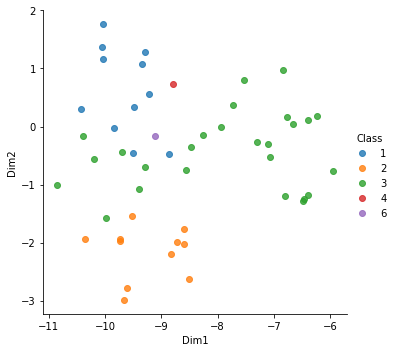

In [ ]:
#Visualize the TSNE, coloring by Class
sns.lmplot(x="Dim1", y="Dim2", data=sequence_tsne_df, hue="Class", fit_reg=False)